# Compute global mean ocean energy imbalance from ECCO Version 4 Release 4

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33763")
client

<Client: 'tcp://127.0.0.1:33763' processes=8 threads=32, memory=58.74 GiB>

In [2]:
import pandas as pd
import sys
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

import matplotlib.pyplot as plt
import json
import time

from dask.distributed import get_worker
from dask import delayed

from pprint import pprint
import requests
import s3fs
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from itertools import repeat
from os.path import expanduser, basename, isfile, isdir, join

## subroutines to compute global mean sea level and trends

In [4]:
def compute_global_mean(field, grid_area, total_grid_cell_area):
    global_mean = (field * grid_area).sum(dim=['latitude','longitude']) / total_grid_cell_area
    global_mean = global_mean.compute()
    return global_mean

In [6]:
def compute_global_mean_trend(global_mean):
    # fit a line
    trend_params = global_mean.polyfit(dim="time", deg=1, full=True)
    global_mean_trend = xr.polyval(coord=global_mean.time,
                                   coeffs=trend_params.polyfit_coefficients)

    return global_mean_trend, trend_params

## subroutines to download files from S3 to the local machine

In [7]:
def download(source, target, redownload_existing=False):
    
    print(target)
    print(source)
    if not os.path.isfile(target) or redownload_existing==True:
        !wget --quiet --continue --output-document $target $source
    else:
        print('not re-downloading')
    return target

In [8]:
def download_file(url: str, out: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    out (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(out):
        raise Exception(f"Output directory doesnt exist! ({out})")
    
    target_file = join(out, basename(url))
    
    # if the file has already been downloaded, skip    
    if isfile(target_file) and force is False:
        print('file exists, and force=False, not re-downloading')
        return 0
    
    with requests.get(url) as r:
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

In [9]:
# download a list of files
def download_files(dls):
    start_time = time.time()

    # use 12 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=12) as executor:
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir)), total=len(dls)))
    
        total_download_size_in_bytes = np.sum(np.array(results))
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

## Define local disk directories

In [10]:
# output directory
output_dir=Path('//home/jpluser/ifenty/ECCO_global_mean_energy_imbalance')
output_dir.mkdir(exist_ok=True)

ECCO_grid_dir =Path('/home/jpluser/ifenty/ECCO_grids/')
ECCO_grid_dir.mkdir(exist_ok=True)

# staging directory
download_dir=Path('/home/jpluser/ifenty/ECCO_global_mean_energy_imbalance/tmp_dl')
download_dir.mkdir(exist_ok=True)

## Connect S3 file system

get keys, pass credentials

In [11]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds

In [12]:
def refresh_s3():
    creds = store_aws_keys()
    s3 = s3fs.S3FileSystem(
        key=creds['AccessKeyId'],
        secret=creds['SecretAccessKey'],
        token=creds['SessionToken'],
        client_kwargs={'region_name':'us-west-2'},
    )
    print(f"\nThe current session token expires at {creds['expiration']}.\n")
    return s3


## Download ECCO grid geometry to local disk

In [13]:
ECCO_grid_filename = 'GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc'
ECCO_grid_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/"

source = ECCO_grid_url + ECCO_grid_filename
target = ECCO_grid_dir / ECCO_grid_filename

local_grid_fname = download(source, target)
ecco_grid = xr.open_dataset(local_grid_fname)
ecco_grid.load()
print(ecco_grid.data_vars)

/home/jpluser/ifenty/ECCO_grids/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc
not re-downloading
Data variables:
    hFacC    (Z, latitude, longitude) float64 nan nan nan nan ... nan nan nan
    Depth    (latitude, longitude) float64 nan nan nan ... 4.178e+03 4.178e+03
    area     (latitude, longitude) float64 1.349e+07 1.349e+07 ... 1.349e+07
    drF      (Z) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    maskC    (Z, latitude, longitude) bool False False False ... False False


## Calculate ECCO grid cell volumes and total ocean volume


In [14]:
# area is grid cell area * land/ocean mask
# volume is grid cell thickness (drF) * area (rA) * partial cell factors (hFacC) * land/ocean mask (maskC)

grid_cell_area = ecco_grid.area * ecco_grid.maskC.isel(Z=0)
grid_cell_vol = ecco_grid.drF * ecco_grid.area * ecco_grid.hFacC * ecco_grid.maskC

total_grid_cell_area= grid_cell_area.sum()
total_grid_cell_area.name = 'Total ECCO ocean area'

total_grid_cell_vol = grid_cell_vol.sum()
total_grid_cell_vol.name = 'Total ECCO ocean volume'

print(f'total grid cell area  {total_grid_cell_area.values/1e9:0.3g} billion km^2')
print(f'total grid cell volume  {total_grid_cell_vol.values/1e9:0.3g} billion km^3')

total grid cell area  3.58e+05 billion km^2
total grid cell volume  1.34e+09 billion km^3


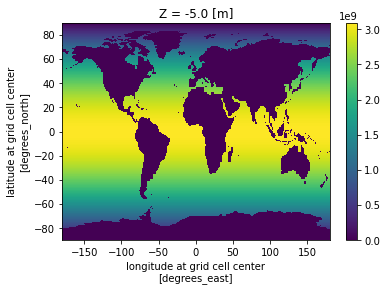

In [15]:
grid_cell_area.plot()

## Find S3 Addresses to ECCO Fields

In [16]:
# PO.DAAC's 'short name' is an identifier for the dataset
ShortName = 'ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4'

In [17]:
# Ask PODAAC for the collection id using the 'short name'
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]
ccid = ummc['meta']['concept-id']
print(f'collection id: {ccid}')

collection id: C1990404812-POCLOUD


In [18]:
# glob to find the NetCDF files associated with this collection id
year = '*'

start_time = time.time()

ss = "podaac-ops-cumulus-protected/" + ShortName + '/*'+ str(year) + '*.nc'

s3 = refresh_s3()
ECCO_s3_files = s3.glob(ss)

print(f'time to find urls: { time.time() - start_time} s\n')

# make a list of just the filenames
ECCO_files =[]
for f in ECCO_s3_files:
    ECCO_files.append(f.split('/')[-1])

pprint(ECCO_files[0])
pprint(ECCO_files[-1])
pprint(ECCO_s3_files[0])
pprint(ECCO_s3_files[-1])


The current session token expires at 2022-07-06 18:15:32+00:00.

time to find urls: 8.551469564437866 s

'OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc'
'OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_2017-12_ECCO_V4r4_latlon_0p50deg.nc'
'podaac-ops-cumulus-protected/ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc'
'podaac-ops-cumulus-protected/ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_2017-12_ECCO_V4r4_latlon_0p50deg.nc'


In [19]:
# convert list of s3 files to urls
ECCO_s3_files_as_http = ['https://archive.podaac.earthdata.nasa.gov/' + f for f in ECCO_s3_files]

# Method 2: Direct S3 Access, parallel=False

parallel must be false else open_mfdataset hangs

# Method 4: Delayed mode

In [20]:
def delayed_global_mean(fn, s3, ecco_grid_area, total_grid_cell_area):
    
    d_start_time = time.time()
    
# works when we open with open_dataset, dask client, and files on S3
    ECCO_ds = xr.open_dataset(s3.open(fn))    

# fails with open_mfdataset, dask client, and files on S3
#    ECCO_SSH_ds = xr.open_mfdataset(s3.open(fn))
        
    global_mean = compute_global_mean(ECCO_ds['oceQnet'], \
                                      ecco_grid_area,\
                                      total_grid_cell_area)
    worker_id = get_worker().id
    
    if worker_id == 'Worker-5fdf7c84-8fd8-47cf-be05-e3c295b5726f':
        tt = time.time() - d_start_time
    else :
        tt = -1
    return global_mean, ECCO_ds.time.values[0]

In [21]:
ecco_grid_area= ecco_grid.area
from dask import delayed,compute


In [22]:
start_time = time.time()

num_granules = 312
result=[]

for fn in ECCO_s3_files[0:num_granules]:
    result.append(delayed(delayed_global_mean)(fn, s3, \
                                               ecco_grid_area, total_grid_cell_area) )

tt = time.time() - start_time

print('append result')
print(f'append result time = {tt:0.3g} s')
 
print('calculate')

global_mean_delayed =np.array(compute(result)).squeeze()
tt = time.time() - start_time

print(f'calc time = {tt:0.3g} s')
print(f'calc time per granule (n={num_granules}) = {tt/num_granules:0.3g} s \n') 

# calculation timing
# ==================
#  64:  2.7s, 0.0416s per granule
# 128:  5.6s, 0.0432s per granule
# 312: 13  s, 0.0416s per granule

append result
append result time = 0.062 s
calculate
calc time = 21.6 s
calc time per granule (n=312) = 0.0691 s 



In [23]:
GM_oceqnet = [x[0].values[0] for x in global_mean_delayed]
GM_time = [x[1] for x in global_mean_delayed]

In [24]:
GM_oceqnet = xr.DataArray(GM_oceqnet, dims=['time'], coords={'time':GM_time})

<xarray.DataArray ()>
array(0.76172494)


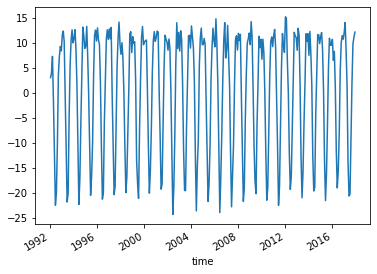

In [25]:
GM_oceqnet.plot()
print(GM_oceqnet.mean())

In [56]:
ECCO_ds.oceQnet

<xarray.DataArray 'oceQnet' (time: 32, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(32, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 1994-08-16T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    direction:              >0 increases potential temperature (THETA)
    long_name:              Net heat flux into the ocean surface
    standard_name:          surface_downward_heat_flux_in_sea_water
    units:                  W m-2
    comment:                Net heat flux into the ocean surface from all pro...
    valid_min:              -842.3851928710938
    valid_max:              381.2687072753906